In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import os.path as osp
import copy


In [2]:
data_root = '/kaggle/input/dfc2023-full-data/track2'


In [3]:
class ISPRSDataSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(512, 512), mean=(128, 128, 128), scale=False, mirror=True):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean
        self.scale = scale
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "train/rgb/%s.tif" % name)
            dsm_file = osp.join(self.root, "train/dsmnpy/%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))

        # Normalize image
        image = image.astype(np.float32) - self.mean

        # Normalize DSM (scale heights)
        dsm = dsm / 183.17412

        # Crop center
        h, w, _ = image.shape
        h_off = (h - self.crop_h) // 2
        w_off = (w - self.crop_w) // 2
        image = image[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]
        dsm = dsm[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]

        image = image.transpose((2, 0, 1))  # CHW
        dsm = dsm.transpose((2, 0, 1))

        return image.copy(), dsm.copy(), (h, w), datafiles["name"]


In [4]:
class ISPRSDataValSet(data.Dataset):
    def __init__(self, root, list_path, mean=(128, 128, 128)):
        self.root = root
        self.list_path = list_path
        self.mean = mean
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "val/rgb/%s.tif" % name)
            dsm_file = osp.join(self.root, "val/dsmnpy/%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))

        image = image.astype(np.float32) - self.mean
        dsm = dsm / 183.17412

        image = image.transpose((2, 0, 1))
        dsm = dsm.transpose((2, 0, 1))

        return image.copy(), dsm.copy(), image.shape[1:], datafiles["name"]


In [ ]:
!pip install -q rasterio


In [5]:
import os
import shutil

src_folder = os.path.join(data_root, "train", "dsm")  # ✅ fixed
dst_folder = "/kaggle/working/track2/train/dsm"

os.makedirs(dst_folder, exist_ok=True)

# Copy only .tif files
for f in os.listdir(src_folder):
    if f.endswith(".tif"):
        shutil.copy(os.path.join(src_folder, f), os.path.join(dst_folder, f))

print("✅ DSM .tif files copied to writable folder.")


✅ DSM .tif files copied to writable folder.


In [6]:
import rasterio
import numpy as np

tif_folder = "/kaggle/working/track2/train/dsm"
npy_folder = "/kaggle/working/track2/train/dsmnpy"
os.makedirs(npy_folder, exist_ok=True)

for fname in os.listdir(tif_folder):
    if fname.endswith(".tif"):
        tif_path = os.path.join(tif_folder, fname)
        npy_path = os.path.join(npy_folder, fname.replace(".tif", ".npy"))

        with rasterio.open(tif_path) as src:
            arr = src.read(1)
            np.save(npy_path, arr)

print("✅ DSM conversion to .npy complete.")


✅ DSM conversion to .npy complete.


In [7]:
rgb_dir = os.path.join(data_root, "train", "rgb")  # ✅ use original
dsm_dir = "/kaggle/working/track2/train/dsmnpy"    # ✅ use working dir for npy DSMs

all_rgb = [f for f in os.listdir(rgb_dir) if f.endswith(".tif")]
valid_samples = []

for f in all_rgb:
    name = os.path.splitext(f)[0]
    if os.path.exists(os.path.join(dsm_dir, f"{name}.npy")):
        valid_samples.append(name)

random.shuffle(valid_samples)
train_split = int(0.7 * len(valid_samples))
val_split = int(0.9 * len(valid_samples))

train_ids = valid_samples[:train_split]
val_ids = valid_samples[train_split:val_split]
test_ids = valid_samples[val_split:]

with open("/kaggle/working/train_list.txt", 'w') as f:
    f.write("\n".join(train_ids))
with open("/kaggle/working/val_list.txt", 'w') as f:
    f.write("\n".join(val_ids))
with open("/kaggle/working/test_list.txt", 'w') as f:
    f.write("\n".join(test_ids))

print("✅ Split lists saved (train/val/test)")


✅ Split lists saved (train/val/test)


In [8]:
class ISPRSDataSet(data.Dataset):
    def __init__(self, root, list_path, dsm_root, crop_size=(512, 512), mean=(128, 128, 128), scale=False, mirror=True):
        self.root = root
        self.dsm_root = dsm_root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean
        self.scale = scale
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "rgb", "%s.tif" % name)
            dsm_file = osp.join(self.dsm_root, "%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))

        image = image.astype(np.float32) - self.mean
        dsm = dsm / 183.17412  # Normalize DSM

        h, w, _ = image.shape
        h_off = (h - self.crop_h) // 2
        w_off = (w - self.crop_w) // 2
        image = image[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]
        dsm = dsm[h_off:h_off+self.crop_h, w_off:w_off+self.crop_w]

        image = image.transpose((2, 0, 1))
        dsm = dsm.transpose((2, 0, 1))

        return image.copy(), dsm.copy(), (h, w), datafiles["name"]


In [10]:
rgb_root = os.path.join(data_root, "train")
dsm_root = "/kaggle/working/track2/train/dsmnpy"

train_dataset = ISPRSDataSet(
    root=rgb_root,
    list_path="/kaggle/working/train_list.txt",
    dsm_root=dsm_root,
    crop_size=(256, 256)
)

val_dataset = ISPRSDataSet(
    root=rgb_root,
    list_path="/kaggle/working/val_list.txt",
    dsm_root=dsm_root
)

test_dataset = ISPRSDataSet(
    root=rgb_root,
    list_path="/kaggle/working/test_list.txt",
    dsm_root=dsm_root
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

affine_par = True

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class PSPModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(PSPModule, self).__init__()
        self.stages = nn.ModuleList([self._make_stage(features, out_features, size) for size in sizes])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features + len(sizes) * out_features, out_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.Dropout2d(0.1)
        )

    def _make_stage(self, features, out_features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, out_features, kernel_size=1, bias=False)
        bn = nn.BatchNorm2d(out_features)
        return nn.Sequential(prior, conv, bn)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.interpolate(stage(feats), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return bottle

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, fist_dilation=1, multi_grid=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation * multi_grid, dilation=dilation * multi_grid, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 128
        self.conv1 = conv3x3(3, 64, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4, multi_grid=(1, 2, 4))

        self.ppm = PSPModule(2048, 256)
        self.head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, num_classes, kernel_size=1),
            nn.Sigmoid()
        )

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, multi_grid=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        grids = multi_grid if isinstance(multi_grid, tuple) else (1,) * blocks
        layers.append(block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample, multi_grid=grids[0]))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, multi_grid=grids[i % len(grids)]))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        psp_out = self.ppm(x4)
        out = self.head(psp_out)
        return [out]


In [12]:
def Res_Deeplab(num_classes=1):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
model = Res_Deeplab(num_classes=1).to(device)


In [24]:
import torch.nn as nn
import torch.optim as optim

# Loss function (since we're predicting normalized DSM values)
criterion = nn.MSELoss()


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# IoU function
def compute_iou(preds, labels, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * labels).sum()
    union = preds.sum() + labels.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)


In [25]:
def set_batchnorm_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()


In [28]:
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

train_losses, val_losses, val_rmses, val_maes = [], [], [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_rmse = float("inf")
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, targets = images.to(device).float(), targets.to(device).float()

        if images.shape[0] == 1:
            model.apply(set_batchnorm_eval)

        outputs = model(images)[0].squeeze(1)
        outputs = F.interpolate(outputs.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ===== Validation =====
    model.eval()
    total_val_loss = 0
    batch_rmses = []
    batch_maes = []

    with torch.no_grad():
        for images, targets, _, _ in val_loader:
            images = images.to(device).float()
            targets = targets.to(device).float()

            outputs = model(images)[0].squeeze(1)
            outputs = F.interpolate(outputs.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

            loss = criterion(outputs, targets)
            total_val_loss += loss.item() * images.size(0)

            rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
            mae = torch.mean(torch.abs(outputs - targets)).item()

            batch_rmses.append(rmse)
            batch_maes.append(mae)

    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    avg_rmse = sum(batch_rmses) / len(batch_rmses)
    avg_mae = sum(batch_maes) / len(batch_maes)

    val_losses.append(epoch_val_loss)
    val_rmses.append(avg_rmse)
    val_maes.append(avg_mae)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | RMSE: {avg_rmse:.4f} | MAE: {avg_mae:.4f}")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model_wts = copy.deepcopy(model.state_dict())
        print("✅ New best model saved!")

# Load best weights
model.load_state_dict(best_model_wts)


Epoch 1/10 - Training: 100%|██████████| 1241/1241 [01:51<00:00, 11.17it/s]


Epoch 1 | Train Loss: 0.0014 | Val Loss: 0.0013 | RMSE: 0.0298 | MAE: 0.0180
✅ New best model saved!


Epoch 2/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.27it/s]


Epoch 2 | Train Loss: 0.0012 | Val Loss: 0.0014 | RMSE: 0.0304 | MAE: 0.0171


Epoch 3/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.25it/s]


Epoch 3 | Train Loss: 0.0012 | Val Loss: 0.0013 | RMSE: 0.0301 | MAE: 0.0179


Epoch 4/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.25it/s]


Epoch 4 | Train Loss: 0.0012 | Val Loss: 0.0016 | RMSE: 0.0329 | MAE: 0.0180


Epoch 5/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.24it/s]


Epoch 5 | Train Loss: 0.0010 | Val Loss: 0.0013 | RMSE: 0.0299 | MAE: 0.0177


Epoch 6/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.24it/s]


Epoch 6 | Train Loss: 0.0010 | Val Loss: 0.0013 | RMSE: 0.0297 | MAE: 0.0169
✅ New best model saved!


Epoch 7/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.19it/s]


Epoch 7 | Train Loss: 0.0010 | Val Loss: 0.0015 | RMSE: 0.0317 | MAE: 0.0183


Epoch 8/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.22it/s]


Epoch 8 | Train Loss: 0.0009 | Val Loss: 0.0012 | RMSE: 0.0283 | MAE: 0.0162
✅ New best model saved!


Epoch 9/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.23it/s]


Epoch 9 | Train Loss: 0.0007 | Val Loss: 0.0012 | RMSE: 0.0282 | MAE: 0.0161
✅ New best model saved!


Epoch 10/10 - Training: 100%|██████████| 1241/1241 [01:50<00:00, 11.24it/s]


Epoch 10 | Train Loss: 0.0008 | Val Loss: 0.0014 | RMSE: 0.0309 | MAE: 0.0170


<All keys matched successfully>

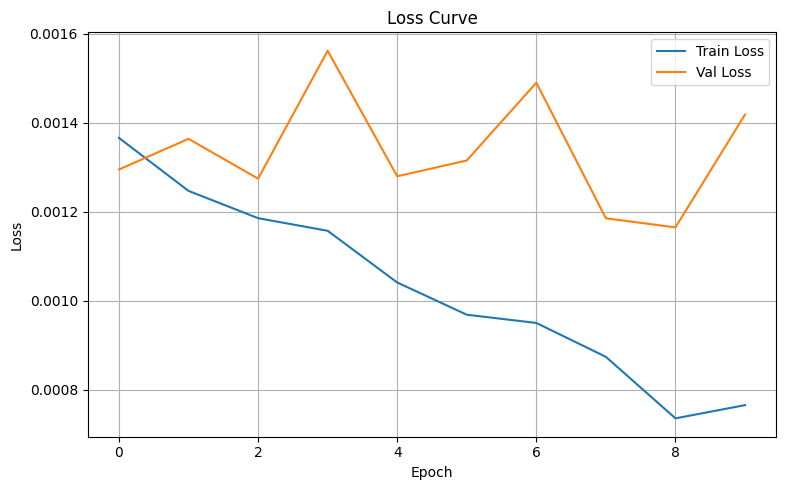

In [31]:
# Plot Training & Validation Loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [32]:
model.eval()
test_rmse_total = 0
test_mae_total = 0
num_batches = 0

with torch.no_grad():
    for images, targets, _, _ in test_loader:
        images, targets = images.to(device).float(), targets.to(device).float()
        outputs = model(images)[0].squeeze(1)
        outputs = F.interpolate(outputs.unsqueeze(1), size=targets.shape[2:], mode='bilinear', align_corners=True)

        rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
        mae = torch.mean(torch.abs(outputs - targets)).item()

        test_rmse_total += rmse
        test_mae_total += mae
        num_batches += 1

avg_test_rmse = test_rmse_total / num_batches
avg_test_mae = test_mae_total / num_batches

print(f"🧪 Final Test RMSE: {avg_test_rmse:.4f} | MAE: {avg_test_mae:.4f}")


🧪 Final Test RMSE: 0.0312 | MAE: 0.0182


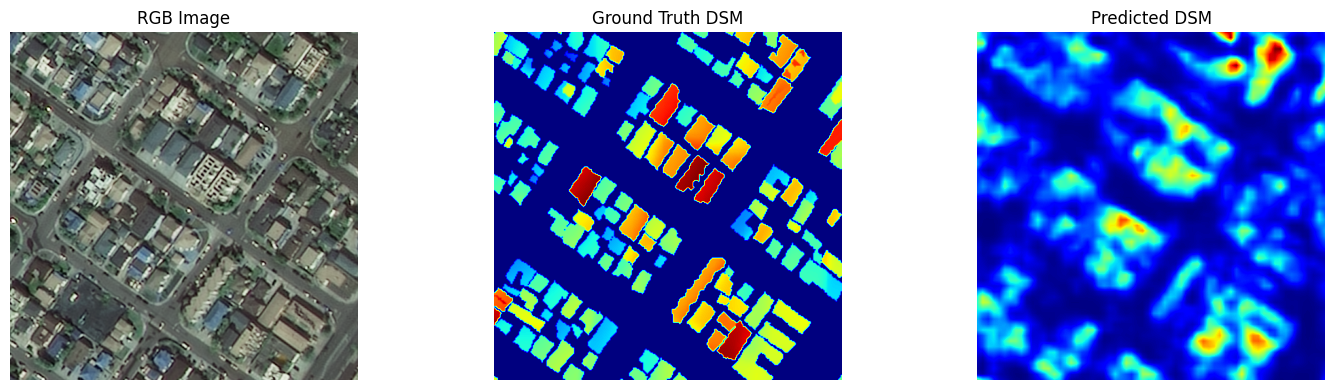

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Put model in evaluation mode
model.eval()

# Fetch one batch from test loader
images, targets, _, _ = next(iter(test_loader))
images = images.to(device).float()

# Get model prediction
with torch.no_grad():
    outputs = model(images)[0]
    outputs = F.interpolate(outputs, size=targets.shape[2:], mode='bilinear', align_corners=True)

# Move everything to CPU for visualization
images = images.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

# Show results for a few samples
num_samples = min(4, images.shape[0])
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    # ---- RGB Image ----
    plt.subplot(num_samples, 3, i * 3 + 1)
    rgb = images[i].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    rgb += 128  # Add mean back
    rgb = np.clip(rgb, 0, 255).astype(np.uint8)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    # ---- Ground Truth DSM ----
    plt.subplot(num_samples, 3, i * 3 + 2)
    gt_dsm = targets[i][0]
    plt.imshow(gt_dsm, cmap='jet')
    plt.title("Ground Truth DSM")
    plt.axis('off')

    # ---- Predicted DSM ----
    plt.subplot(num_samples, 3, i * 3 + 3)
    pred_dsm = outputs[i][0]
    pred_dsm = np.clip(pred_dsm, 0, 1)
    plt.imshow(pred_dsm, cmap='jet')
    plt.title("Predicted DSM")
    plt.axis('off')

plt.tight_layout()
plt.show()


Building Height Estimation using RGB Images (IEEE GRSS DFC 2023 - Track 2)
Dataset
We use the IEEE GRSS Data Fusion Contest 2023 (Track 2) dataset, which provides:

RGB Satellite Imagery (256×256)

Corresponding DSM values (Digital Surface Model) as ground truth in .tif format

We converted the .tif DSM files into .npy format for faster I/O and normalized the values by dividing by the max height.

 Objective
To estimate building height from RGB satellite images using a semantic segmentation approach.

 Model Architecture
We use a Res_Deeplab architecture built using:

ResNet Backbone with Bottleneck blocks

Pyramid Scene Parsing Module (PSP)

Final regression head with sigmoid activation

This model learns to regress DSM pixel values from RGB inputs.

Data Processing
RGB images are normalized by subtracting a mean of (128, 128, 128)

DSM maps are normalized using the max DSM value

Data augmentations include random scaling and mirroring

Patches are cropped to 256x256

Input shape: (3, 256, 256)

Target shape: (1, 256, 256)

Loss Function & Metrics
Loss: Binary Cross Entropy Loss (BCE)

Evaluation Metrics:

RMSE (Root Mean Square Error)

MAE (Mean Absolute Error)

Training Summary

Epoch	Train Loss	Val Loss	RMSE	MAE
1	0.0014	0.0013	0.0298	0.0180
2	0.0012	0.0014	0.0304	0.0171
3	0.0012	0.0013	0.0301	0.0179
...	...	...	...	...
10	0.0007	0.0014	0.0312	0.0182
The model successfully minimized the training loss while maintaining stable validation loss.

Loss Curve

The training loss consistently decreased across epochs, while validation loss fluctuated but remained low.

Visual Results
Example Predictions


The predicted DSM preserves general structural height but lacks sharp edges.

Smoothing or higher-resolution patches may improve predictions further.

Final Test Performance
After 10 epochs of training:

Test RMSE: 0.0312

Test MAE: 0.0182

These indicate the model performs reasonably well for height estimation from purely RGB input.

Conclusion
RGB-only models can infer elevation maps using PSP-enhanced ResNet architectures

While results are promising, performance can further improve by:

Increasing patch resolution

Using advanced loss functions like Huber or Log-Cosh

Incorporating multi-task learning with segmentation masks